# converted to mongodb data

In [13]:
from pymongo import MongoClient
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import pandas as pd

# Connect to your MongoDB instance
client = MongoClient('mongodb://localhost:27017/')
db = client['vaers']  
collection = db['reports']  


# Mortalities per Year (1990-2023)

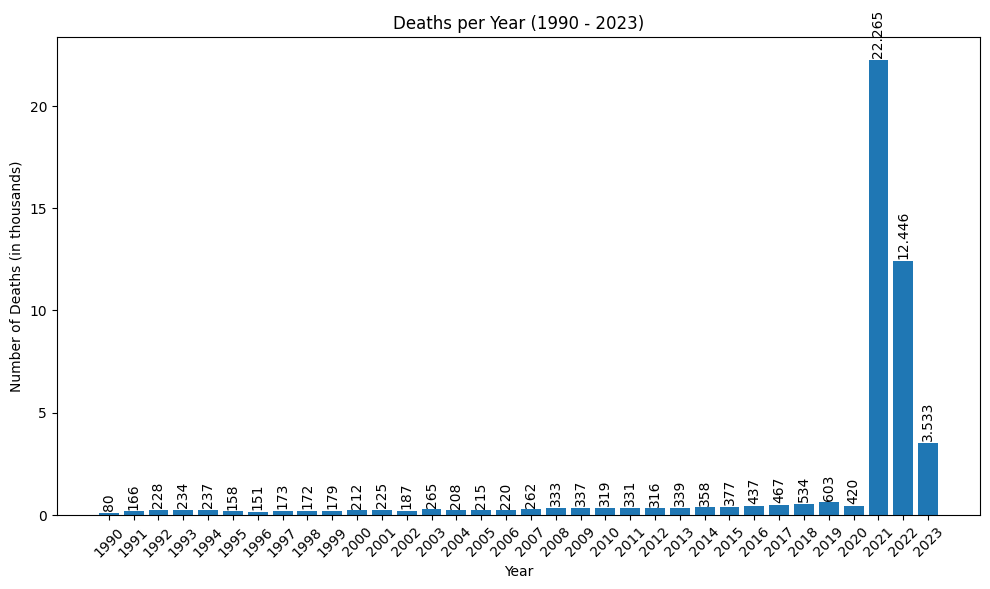

In [2]:
# Custom formatter function for y-axis in thousands
def thousands_formatter(y):
    return f'{int(y / 1000)}'

# MongoDB aggregation pipeline to calculate deaths per year
pipeline = [
    {"$match": {"DIED": "Y"}},  # Match documents where DIED field is "Y"
    {"$addFields": {"year": {"$year": {"$toDate": "$RECVDATE"}}}},  # Extract year from RECVDATE
    {"$group": {"_id": "$year", "count": {"$sum": 1}}},  # Group by year and count deaths
    {"$sort": {"_id": 1}}  # Sort by year in ascending order
]

# Execute the aggregation pipeline
deaths_per_year = list(collection.aggregate(pipeline))

# Extract years and death counts from the aggregation result
years = [entry["_id"] for entry in deaths_per_year]
death_counts = [entry["count"] for entry in deaths_per_year]

# Plotting the data
plt.figure(figsize=(10, 6))
bars = plt.bar(years, death_counts)

# Set the y-axis formatter for thousands
formatter = FuncFormatter(thousands_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Year')
plt.ylabel('Number of Deaths (in thousands)')
plt.title('Deaths per Year (1990 - 2023)')

# Annotating each bar with its value, formatted with a dot for thousands
for bar in bars:
    height = bar.get_height()
    formatted_height = f'{int(height):,}'.replace(',', '.')  # Format with a dot for thousands
    plt.text(bar.get_x() + bar.get_width() / 2, height + 100, formatted_height,
             ha='center', va='bottom', rotation=90)

plt.xticks(years, rotation=45)

plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Mortality_Rate/Deaths_per_Year.png')
plt.show()

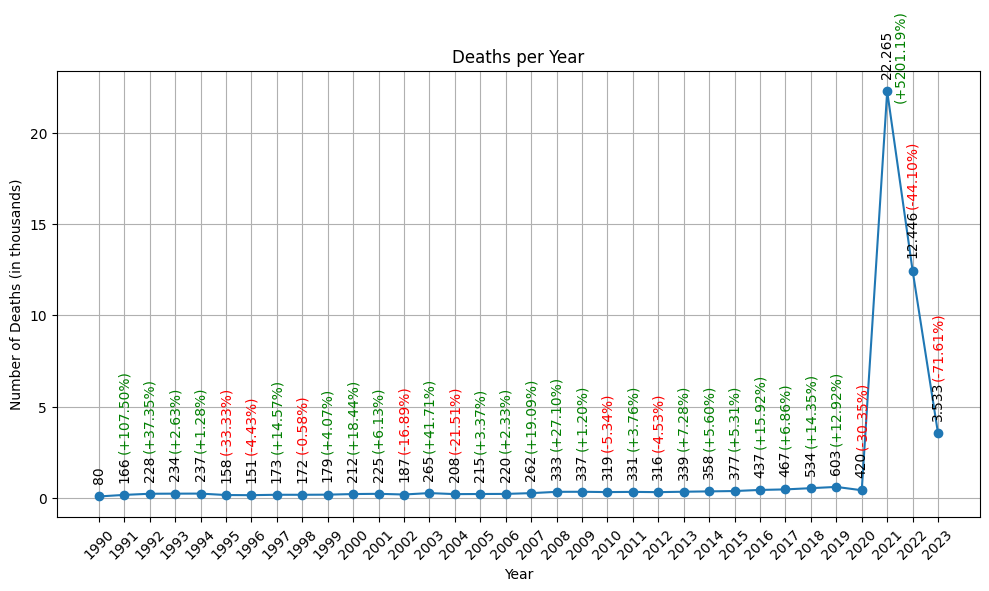

In [105]:
# Custom formatter function for y-axis in thousands
def thousands_formatter(y):
    return f'{int(y / 1000)}'

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017")
db = client["vaers"]
collection = db["reports"]

deaths_per_year = {}

# Aggregate death count per year
pipeline = [
    {"$match": {"DIED": "Y"}},
    {"$group": {"_id": {"$year": "$RECVDATE"}, "count": {"$sum": 1}}}
]

# Execute the aggregation pipeline
result = collection.aggregate(pipeline)

# Convert the result to a dictionary
for entry in result:
    year = entry["_id"]
    deaths = entry["count"]
    deaths_per_year[year] = deaths

# Convert dictionary to a DataFrame
df = pd.DataFrame.from_dict(deaths_per_year, orient='index', columns=['Deaths'])
df.index.name = 'Year'

# Sort the DataFrame by index (year)
df = df.sort_index()

# Calculate percentage change and add it to the DataFrame
df['Percentage Change'] = df['Deaths'].pct_change() * 100
df['Percentage Change'] = df['Percentage Change'].fillna(0)  # Fill NaN (first row) with 0

# Plotting the data as a 2D line graph with original matplotlib blue color
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Deaths'], marker='o', linestyle='-')  # Use 'b' for original blue color
plt.xlabel('Year')
plt.ylabel('Number of Deaths (in thousands)')
plt.title('Deaths per Year')

# Set the y-axis formatter for thousands
formatter = FuncFormatter(thousands_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Annotate each point with its value (formatted_deaths) in black
for year, deaths in zip(df.index, df['Deaths']):
    formatted_deaths = f'{int(deaths):,}'.replace(',', '.')  # Format with a dot for thousands
    plt.annotate(formatted_deaths, (year, deaths + 100), textcoords="offset points", xytext=(0, 10),
                 ha='center', fontsize=10, rotation=90, color='black')

# Annotate each point with its percentage change (pct_change) in red or green
for year, pct_change, formatted_deaths in zip(df.index, df['Percentage Change'], df['Deaths']):
    color = 'green' if pct_change > 0 else 'red' if pct_change < 0 else 'black'
    annotation_text = f'({pct_change:+.2f}%)'
    
    # Skip annotating the percentage value for the first year
    if year == df.index[0]:
        continue
    
    # Set offset based on formatted_deaths value
    if formatted_deaths < 1000:
        offset = 1650
        xoffset = 0
    elif formatted_deaths < 10000:
        offset = 2300
        xoffset = 0
    elif formatted_deaths < 20000:
        offset = 2800
        xoffset = 0
    else:
        offset = -1200
        xoffset = 0.5
    
    plt.annotate(annotation_text, (year + xoffset, formatted_deaths + offset), textcoords="offset points", xytext=(0, 10),
                 ha='center', fontsize=10, rotation=90, color=color)

# Set x-ticks to the years in the dataset
plt.xticks(df.index, rotation=45)

plt.tight_layout()
plt.grid(True)
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Mortality_Rate/Deaths_per_Year_dotted.png')
plt.show()

# Mortality Rate per Year (1990-2023)

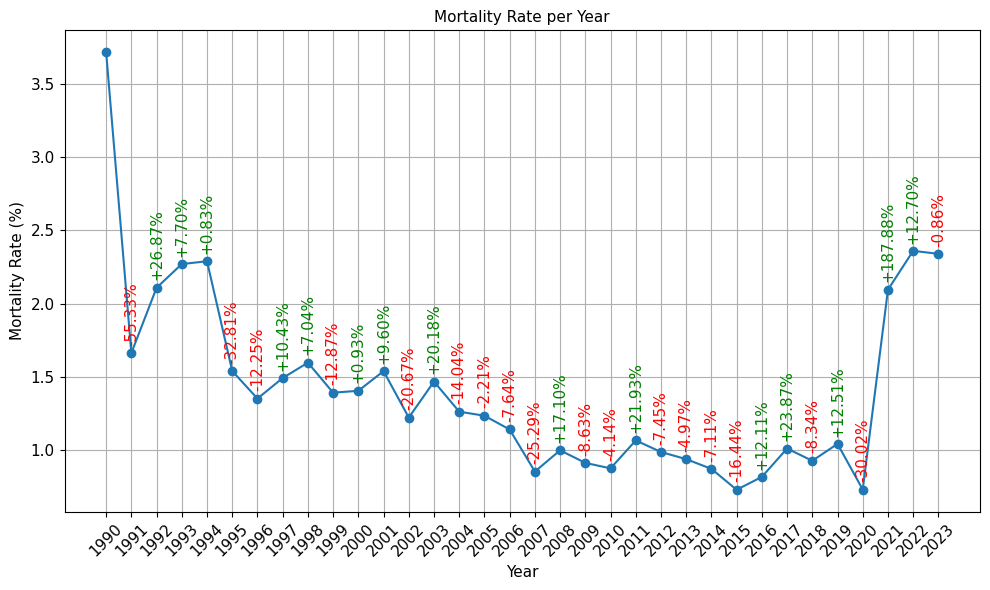

In [20]:
# MongoDB aggregation pipeline to calculate mortality rate per year
pipeline = [
    {"$group": {
        "_id": {"$year": "$RECVDATE"},
        "total_entries": {"$sum": 1},
        "deaths": {"$sum": {"$cond": [{"$eq": ["$DIED", "Y"]}, 1, 0]}}
    }},
    {"$project": {
        "_id": 0,
        "year": "$_id",
        "total_entries": "$total_entries",
        "deaths": "$deaths",
        "mortality_rate": {"$cond": [{"$gt": ["$total_entries", 0]}, {"$multiply": [{"$divide": ["$deaths", "$total_entries"]}, 100]}, 0]}
    }},
    {"$sort": {"year": 1}}
]

# Execute the aggregation pipeline
result = list(collection.aggregate(pipeline))

# Extracting years, total_entries, deaths, and mortality rates from the aggregation result
years = [entry['year'] for entry in result]
total_entries = [entry['total_entries'] for entry in result]
deaths = [entry['deaths'] for entry in result]
mortality_rates = [entry['mortality_rate'] for entry in result]

# Calculate the percentage change compared to the previous year
percent_changes = {}
previous_rate = None
for i in range(1, len(mortality_rates)):
    year = years[i]
    rate = mortality_rates[i]
    previous_rate = mortality_rates[i - 1]
    percent_change = ((rate - previous_rate) / previous_rate) * 100 if previous_rate > 0 else 0
    percent_changes[year] = percent_change

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(years, mortality_rates, marker='o')

plt.xlabel('Year', fontsize = 11)
plt.ylabel('Mortality Rate (%)', fontsize = 11)
plt.title('Mortality Rate per Year', fontsize = 11)
plt.xticks(years, rotation=45)

# Annotating each point with the percentage change
for year, percent_change in percent_changes.items():
    x_pos = years.index(year)
    y_pos = mortality_rates[x_pos]
    color = 'green' if percent_change > 0 else 'red'
    sign = '+' if percent_change > 0 else ''
    plt.text(year, y_pos + 0.05, f"{sign}{percent_change:.2f}%", rotation=90, color=color, va='bottom', ha='center', fontsize = 11)

plt.grid(True)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.tight_layout()
plt.savefig('/home/sebastian/Documents/Masterarbeit/Plots/Data_Exploration/Mortality_Rate/Mortality_Rate_per_Year.pdf')
plt.show()


# Highest Mortality Rates per Vaccine Type (1990-2023)

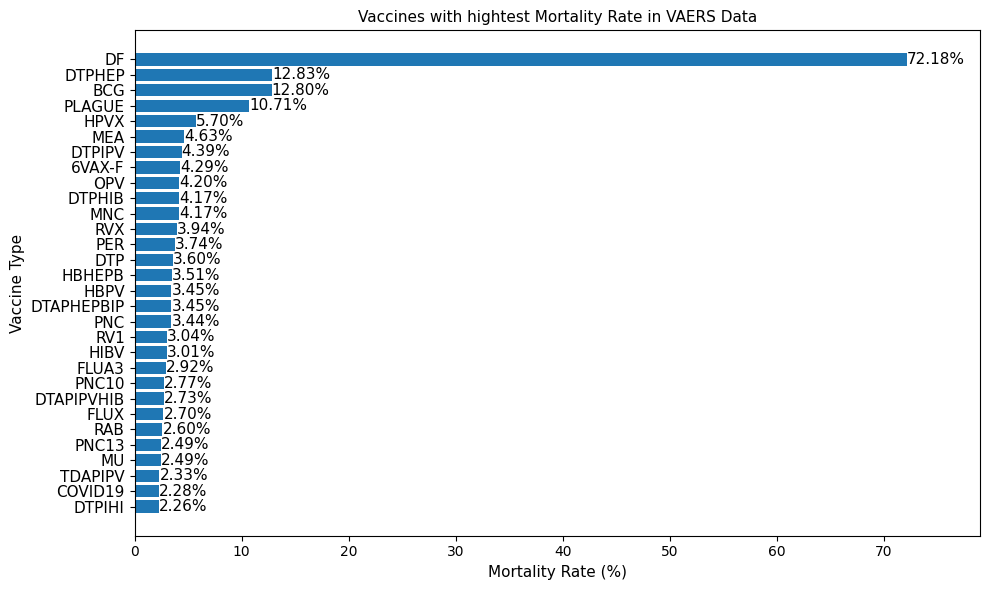

In [19]:
pipeline = [
    {
        "$unwind": "$vax_data"
    },
    {
        "$group": {
            "_id": {
                "VAERS_ID": "$VAERS_ID",
                "VAX_TYPE": {
                    "$cond": {
                        "if": { "$eq": ["$vax_data.VAX_TYPE", "COVID19-2"] },
                        "then": "COVID19",
                        "else": "$vax_data.VAX_TYPE"
                    }
                }
            },
            "DIED": { "$first": "$DIED" }
        }
    },
    {
        "$group": {
            "_id": "$_id.VAX_TYPE",
            "count": { "$sum": 1 },
            "deaths": {
                "$sum": {
                    "$cond": [{ "$eq": ["$DIED", "Y"] }, 1, 0]
                }
            }
        }
    },
    {
        "$project": {
            "Vaccine Type": "$_id",
            "Total Vaccine Occurrences": "$count",
            "Total Deaths": "$deaths",
            "Mortality Rate (%)": {
                "$multiply": [
                    { "$divide": ["$deaths", "$count"] },
                    100
                ]
            },
            "_id": 0
        }
    },
    {
        "$sort": { "Mortality Rate (%)": -1 }
    },
    {
        "$limit": 30
    }
]

# Execute the pipeline with allowDiskUse option
result = list(collection.aggregate(pipeline, allowDiskUse=True))


# Extract data for plotting
vaccine_types = [entry["Vaccine Type"] for entry in result]
mortality_rates = [entry["Mortality Rate (%)"] for entry in result]

# Plotting
plt.figure(figsize=(10, 6))
plt.xlim(0,79)
bars = plt.barh(vaccine_types, mortality_rates)
plt.xlabel('Mortality Rate (%)', fontsize = 11)
plt.ylabel('Vaccine Type', fontsize = 11)
plt.title('Vaccines with hightest Mortality Rate in VAERS Data', fontsize = 11)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest rate at the top
plt.yticks(fontsize = 11)

for bar, rate in zip(bars, mortality_rates):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{rate:.2f}%', 
             va='center', ha='left', fontsize = 11)

plt.tight_layout()
plt.savefig('/home/sebastian/Documents/Masterarbeit/Plots/Data_Exploration/Mortality_Rate/Highest_Mortality_Rate_per_Vaccine_Type.pdf')
plt.show()


In [7]:
# Define the mapping from abbreviations to full vaccine names
vaccine_name_mapping = {
    "6VAX-F": "Diphtheria and tetanus toxoids and acellular pertussis adsorbed + inactivated poliovirus + hepatitis B + haemophilus B conjugate vaccine",
    "ADEN": "Adenovirus vaccine live oral type 7",
    "ADEN_4_7": "Adenovirus type 4 and 7 vaccine, live oral",
    "ANTH": "Anthrax vaccine",
    "BCG": "Bacillus Calmette-Guerin vaccine",
    "CEE": "Central European encephalitis",
    "CHOL": "Cholera vaccine",
    "COVID19": "Coronavirus 2019 vaccine",
    "COVID19-2": "Coronavirus 2019 vaccine, bivalent",
    "DF": "Dengue fever vaccine",
    "DPIPV": "Diphtheria, pertussis + inactivated polio virus",
    "DPP": "Diphtheria/pertussis/polio (oral [live or inactivated not noted])",
    "DT": "Diphtheria and tetanus toxoids, pediatric",
    "DTAP": "Diphtheria and tetanus toxoids and acellular pertussis vaccine",
    "DTAPH": "Diphtheria and tetanus toxoids and acellular pertussis vaccine + haemophilus B conjugate vaccine",
    "DTAPHIBIP": "Diphtheria and tetanus toxoids and acellular pertussis vaccine + hepatitis B + inactivated poliovirus vaccine",
    "DTAPIPV": "Diphtheria and tetanus toxoids and acellular pertussis vaccine + inactivated poliovirus vaccine",
    "DTAPIPVHIB": "Diphtheria and tetanus toxoids and acellular pertussis vaccine + inactivated poliovirus vaccine + haemophilus B conjugate vaccine",
    "DTIPV": "Diphtheria and tetanus toxoids, pediatric + inactivated poliovirus vaccine",
    "DTOX": "Diphtheria toxoid",
    "DTP": "Diphtheria and tetanus toxoids and pertussis vaccine",
    "DTPHEP": "Diphtheria, tetanus, pertussis + hepatitis B",
    "DTPHIB": "Diphtheria and tetanus toxoids and pertussis vaccine + haemophilus B conjugate vaccine",
    "DTPIHI": "Diphtheria/tetanus/whole pertussis + inactivated polio virus + haemophilus influenza B",
    "DTPIPV": "Diphtheria and tetanus toxoids and pertussis vaccine + inactivated poliovirus vaccine",
    "DTPPHIB": "Diphtheria and tetanus toxoids and pertussis vaccine + inactivated poliovirus vaccine + haemophilus B conjugate vaccine (tetanus toxoid conjugate)",
    "DTPPVHBHPB": "Diphtheria and tetanus toxoids and acellular pertussis, inactivated poliovirus, haemophilus B conjugate and hepatitis B vaccine",
    "EBZR": "Ebola Zaire vaccine",
    "FLU(H1N1)": "Influenza (H1N1) monovalent",
    "FLU3": "Influenza virus vaccine, trivalent",
    "FLU4": "Influenza virus vaccine, quadrivalent",
    "FLUA3": "Influenza virus vaccine, trivalent, adjuvant",
    "FLUA4": "Influenza virus vaccine, quadrivalent, adjuvant",
    "FLUC3": "Influenza virus vaccine, trivalent, cell-culture-derived",
    "FLUC4": "Influenza virus vaccine, quadrivalent, cell-culture-derived",
    "FLUN(H1N1)": "Influenza (H1N1) monovalent (nasal spray)",
    "FLUN3": "Influenza virus vaccine (nasal spray)",
    "FLUN4": "Influenza virus vaccine quadrivalent (nasal spray)",
    "FLUR3": "Influenza virus vaccine, trivalent, recombinant",
    "FLUR4": "Influenza virus vaccine, quadrivalent, recombinant",
    "FLUX": "Influenza virus vaccine, unknown manufacturer",
    "FLUX(H1N1)": "Influenza (H1N1) monovalent, unknown manufacturer",
    "H5N1": "Pandemic flu vaccine",
    "HBHEPB": "Haemophilus B conjugate vaccine + hepatitis B",
    "HBPV": "Haemophilus b polysaccharide vaccine",
    "HEP": "Hepatitis B virus vaccine",
    "HEPA": "Hepatitis A",
    "HEPAB": "Hepatitis A + hepatitis B",
    "HEPATYP": "Inactivated hepatitis a + typhoid polysaccharide vaccine adsorbed",
    "HIBV": "Haemophilus B conjugate vaccine",
    "HPV2": "Human papillomavirus bivalent",
    "HPV4": "Human papillomavirus quadrivalent",
    "HPV9": "Human papillomavirus 9-valent",
    "HPVX": "Human papillomavirus (no brand name)",
    "IPV": "Poliovirus vaccine inactivated",
    "JEV": "Japanese encephalitis virus vaccine, inactivated",
    "JEV1": "Japanese encephalitis virus vaccine, inactivated",
    "JEVX": "Japanese encephalitis virus vaccine (no brand name)",
    "LYME": "Lyme disease vaccine",
    "MEA": "Measles",
    "MEN": "Meningococcal polysaccharide vaccine",
    "MENB": "Meningococcal group b vaccine, rDNA absorbed",
    "MENHIB": "Meningococcal conjugate + Hib",
    "MER": "Measles and rubella virus vaccine, live",
    "MM": "Measles and mumps virus vaccine, live",
    "MMR": "Measles, mumps and rubella virus vaccine, live",
    "MMRV": "Measles, mumps, rubella and varicella vaccine live",
    "MNC": "Meningococcal conjugate vaccine",
    "MNQ": "Meningococcal conjugate vaccine",
    "MNQHIB": "Meningococcal groups c and y + haemophilus B tetanus toxoid conjugate vaccine",
    "MU": "Mumps virus vaccine, live",
    "MUR": "Mumps and rubella virus vaccine, live",
    "OPV": "Poliovirus vaccine trivalent, live, oral",
    "PER": "Pertussis vaccine",
    "PLAGUE": "Plague vaccine",
    "PNC": "Pneumococcal 7-valent conjugate vaccine",
    "PNC10": "Pneumococcal 10-valent conjugate vaccine",
    "PNC13": "Pneumococcal 13-valent conjugate vaccine",
    "PNC15": "Pneumococcal 15-Valent conjugate vaccine",
    "PNC20": "Pneumococcal 20-Valent conjugate vaccine",
    "PPV": "Pneumococcal vaccine, polyvalent",
    "RAB": "Rabies virus vaccine",
    "RSV": "Respiratory syncytial virus vaccine",
    "RUB": "Rubella",
    "RV": "Rotavirus vaccine, live, oral, tetravalent",
    "RV1": "Rotavirus vaccine, live, oral",
    "RV5": "Rotavirus vaccine, live, oral, pentavalent",
    "RVX": "Rotavirus (no brand name)",
    "SMALL": "Smallpox vaccine",
    "SMALLMNK": "Smallpox + monkeypox vaccine",
    "SSEV": "Spring/summer encephalitis vaccine",
    "TBE": "Tick-borne encephalitis vaccine",
    "TD": "Tetanus and diphtheria toxoids, adult",
    "TDAP": "Tetanus toxoid, reduced diphtheria toxoid and acellular pertussis vaccine, adsorbed",
    "TDAPIPV": "Tetanus, diphtheria and acellular pertussis, and inactivated polio virus",
    "TTOX": "Tetanus toxoid",
    "TYP": "Typhoid vaccine",
    "UNK": "Unknown vaccine type",
    "VARCEL": "Varivax-varicella virus live",
    "VARZOS": "Varicella-zoster vaccine",
    "YF": "Yellow fever vaccine"
}


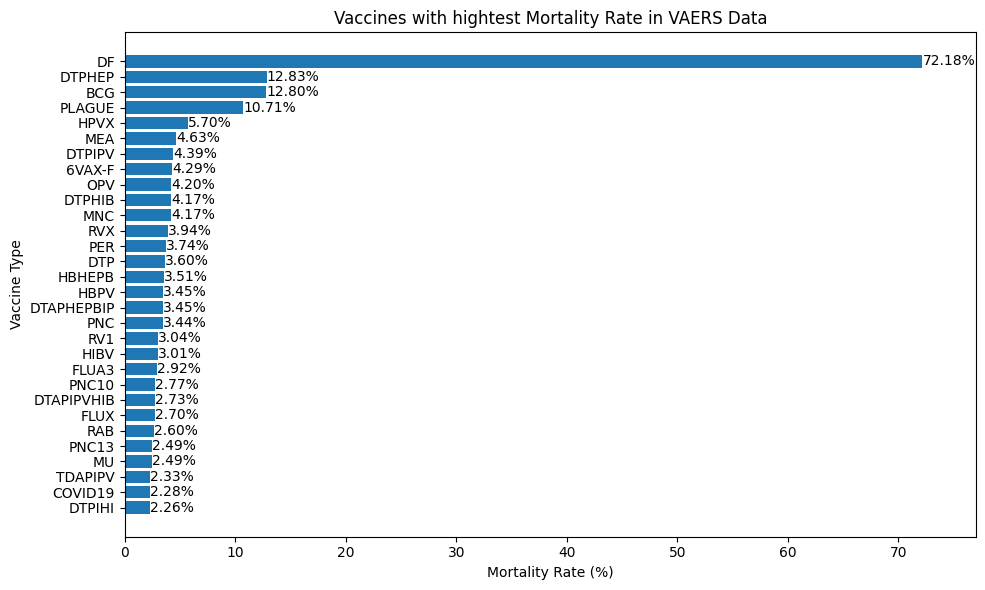

In [12]:
pipeline = [
    {
        "$unwind": "$vax_data"
    },
    {
        "$group": {
            "_id": {
                "VAERS_ID": "$VAERS_ID",
                "VAX_TYPE": {
                    "$cond": {
                        "if": { "$eq": ["$vax_data.VAX_TYPE", "COVID19-2"] },
                        "then": "COVID19",
                        "else": "$vax_data.VAX_TYPE"
                    }
                }
            },
            "DIED": { "$first": "$DIED" }
        }
    },
    {
        "$group": {
            "_id": "$_id.VAX_TYPE",
            "count": { "$sum": 1 },
            "deaths": {
                "$sum": {
                    "$cond": [{ "$eq": ["$DIED", "Y"] }, 1, 0]
                }
            }
        }
    },
    {
        "$project": {
            "Vaccine Type": "$_id",
            "Total Vaccine Occurrences": "$count",
            "Total Deaths": "$deaths",
            "Mortality Rate (%)": {
                "$multiply": [
                    { "$divide": ["$deaths", "$count"] },
                    100
                ]
            },
            "_id": 0
        }
    },
    {
        "$sort": { "Mortality Rate (%)": -1 }
    },
    {
        "$limit": 30
    }
]

# Execute the pipeline with allowDiskUse option
result = list(collection.aggregate(pipeline, allowDiskUse=True))


# Extract data for plotting
vaccine_types = [entry["Vaccine Type"] for entry in result]
mortality_rates = [entry["Mortality Rate (%)"] for entry in result]

# Plotting
plt.figure(figsize=(10, 6))
plt.xlim(0,77)
bars = plt.barh(vaccine_types, mortality_rates)
plt.xlabel('Mortality Rate (%)')
plt.ylabel('Vaccine Type')
plt.title('Vaccines with hightest Mortality Rate in VAERS Data')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest rate at the top

for bar, rate in zip(bars, mortality_rates):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{rate:.2f}%', 
             va='center', ha='left')

plt.tight_layout()
plt.savefig('/home/sebastian/Documents/Masterarbeit/Plots/Data_Exploration/Mortality_Rate/Highest_Mortality_Rate_per_Vaccine_Type.pdf')
plt.show()


In [10]:
vaccine_types

['DF',
 'DTPHEP',
 'BCG',
 'PLAGUE',
 'HPVX',
 'MEA',
 'DTPIPV',
 '6VAX-F',
 'OPV',
 'DTPHIB',
 'MNC',
 'RVX',
 'PER',
 'DTP',
 'HBHEPB',
 'HBPV',
 'DTAPHEPBIP',
 'PNC',
 'RV1',
 'HIBV',
 'FLUA3',
 'PNC10',
 'DTAPIPVHIB',
 'FLUX',
 'RAB',
 'PNC13',
 'MU',
 'TDAPIPV',
 'COVID19',
 'DTPIHI']